In [1]:
#https://karpathy.github.io/2015/05/21/rnn-effectiveness/

#https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html
##https://medium.com/@nateparrott/give-your-kids-futuristic-names-with-a-neural-network-9078bed0894d
import string
import pathlib

import torch
import pandas as pd
import torch.nn as nn
from ipywidgets import interact_manual

In [3]:
df = pd.DataFrame(columns=["state", "gender", "year", "name", "number"])
for path in pathlib.Path('/data').glob('*.TXT'):
    state = pd.read_csv(path, names=["state", "gender", "year", "name", "number"], header=None)
    df = df.append(state)
df = df.astype({'number':'int64'})
df.head()

,state,gender,year,name,number
0,IN,F,1910,Mary,619
1,IN,F,1910,Helen,324
2,IN,F,1910,Ruth,238
3,IN,F,1910,Dorothy,215
4,IN,F,1910,Mildred,200


In [4]:
names_df = df.drop_duplicates(['state','name'],keep= 'last')
names_df.head()

,state,gender,year,name,number
1449,IN,F,1914,Nondas,5
1767,IN,F,1915,Allegra,8
1781,IN,F,1915,Kathlyn,8
1816,IN,F,1915,Tressie,7
1823,IN,F,1915,Blanch,6


In [5]:
print(len(names_df), len(df))

299921 6028151


In [6]:
all_letters = string.ascii_letters
n_letters = len(all_letters) + 1 # Plus EOS marker
print(all_letters)
all_states = names_df.state.unique().tolist()
n_states = len(all_states)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ


In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(n_states + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_states + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [8]:
import random
def random_training_pair():
    choice = random.randint(0, len(names_df) - 1)
    row = names_df.iloc[choice]
    return row["state"], row["name"]

random_training_pair()

('CT', 'Tamia')

In [9]:
def stateTensor(state):
    i = all_states.index(state)
    tensor = torch.zeros(1, n_states)
    tensor[0][i] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for i, letter in enumerate(name):
        tensor[i][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(name):
    letter_indexes = [all_letters.find(letter) for letter in name[1:]]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [10]:
def random_training_example():
    state, name = random_training_pair()
    state_tensor = stateTensor(state)
    name_tensor = inputTensor(name)
    target_tensor = targetTensor(name)
    return state_tensor, name_tensor, target_tensor

random_training_example()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0.]],
 
         [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
           0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [20]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        print(output.size(), target_line_tensor[i].size())
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [12]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [21]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for i in range(1, n_iters + 1):
    output, loss = train(*random_training_example())
    total_loss += loss

    if i % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), i, i / n_iters * 100, loss))

    if i % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Si

torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Si

torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Si

torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Si

torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Size([1])
torch.Size([1, 53]) torch.Si

KeyboardInterrupt: 

In [108]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = stateTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
@interact_manual
def samples(states=list(names_df.state.unique()), start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(states, start_letter))

interactive(children=(Dropdown(description='states', options=('IN', 'IL', 'KS', 'SC', 'HI', 'GA', 'SD', 'CO', …

In [97]:
samples('PA', 'ST')

Shande
Tarisa


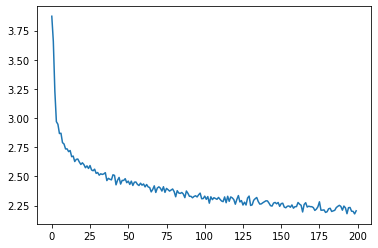

In [95]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)